Populating the interactive namespace from numpy and matplotlib
Cu_orbs =  ['d3z2r2', 'dx2y2', 'dxy', 'dxz', 'dyz']
O1_orbs =  ['px']
O2_orbs =  ['py']
symmetries =  ['ALL']
E_1S =  12.66
E_1G =  8.26
E_1D =  7.21
E_3P =  7.55
E_3F =  5.3
Mc= 5
VS.dim =  1681
No. of states with count_upup, count_updn, count_dnup, count_dndn: 0 871 810 0
start create_tpd_nn_matrix
start create_tpp_nn_matrix
start create_edep_diag_matrix
len(d_list) 25 Nd= 45
start calculating eigenvalues of CuO4 problem
orbitals in sym  1A1 =  [('dyz', 'dyz'), ('dxz', 'dxz'), ('dxy', 'dxy'), ('d3z2r2', 'd3z2r2'), ('dx2y2', 'dx2y2')]
dd_state_indices 510 , state: S=  0  Sz=  0 orb=  dx2y2 dx2y2
orbitals in sym  1A2 =  [('dx2y2', 'dxy')]
dd_state_indices 511 , state: S=  0  Sz=  0 orb=  dxy dx2y2
orbitals in sym  3A2 =  [('dxz', 'dyz'), ('dx2y2', 'dxy')]
dd_state_indices 515 , state: S=  1  Sz=  0 orb=  dx2y2 dxy
orbitals in sym  1B1 =  [('d3z2r2', 'dx2y2'), ('dxz', 'dxz'), ('dyz', 'dyz')]
dd_state_indices 505 , state: S= 

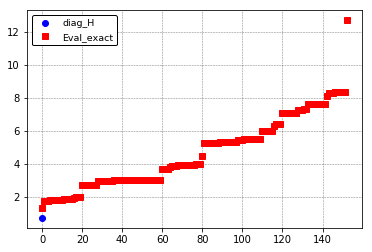

In [1]:
%pylab inline

import math
import numpy as np
from scipy.sparse.linalg import inv
#from numpy.linalg import inv
import scipy.sparse as sps
import scipy.sparse.linalg
from scipy import integrate
import sys
import matplotlib.pyplot as plt
sys.path.append('../../src/')
from pylab import *

import parameters as pam
import lattice as lat
import variational_space as vs
import hamiltonian as ham
import basis_change as basis
import lanczos

M_PI = math.pi
Mc  = pam.Mc
print 'Mc=',Mc

w_vals = pam.w_vals
Norb = pam.Norb
eta = pam.eta
ed  = pam.ed
ep  = pam.eps[0]

if Norb==3 or Norb==7:
    tpd = pam.tpds[0]
    tpp = pam.tpps[0]
elif Norb==9:
    pds = pam.pds
    pdp = pam.pdp
    pps = pam.pps
    ppp = pam.ppp
    
Upp = pam.Upps[0]
if Norb==3:
    Udd = pam.Udd
elif Norb==7 or Norb==9:
    A = pam.A
    B = pam.B
    C = pam.C

#####################################
def get_ground_state(matrix,S_val,Sz_val):  
    '''
    Obtain the ground state info, namely the lowest peak in Aw_dd's component
    in particular how much weight of various d8 channels: a1^2, b1^2, b2^2, e^2
    '''            
    print 'start getting ground state'
    # in case eigsh does not work but matrix is actually small, e.g. Mc=1 (CuO4)
    M_dense = matrix.todense()
    #print 'H='
    #print M_dense
    #vals, vecs = np.linalg.eigh(M_dense)
    #Neval = M_dense.shape[0]
    #print Neval
    
    # in case eigsh works:
    Neval = 1
    vals, vecs = sps.linalg.eigsh(matrix, k=Neval, which='SA')
    print 'lowest eigenvalue of H = '
    print vals
    
    # get state components in GS and another 9 higher states; note that indices is a tuple
    for k in xrange(0,Neval):
        #if vals[k]<pam.w_start or vals[k]>pam.w_stop:
        #if vals[k]<11.5 or vals[k]>14.5:
        #if k<Neval:
        #    continue
            
        #print 'eigenvalue = ', vals[k]
        indices = np.nonzero(abs(vecs[:,k])>0.01)

        #print "Compute the weights in GS (lowest Aw peak)"
        for i in indices[0]:
            # state is original state but its orbital info remains after basis change
            state = VS.get_state(VS.lookup_tbl[i])
            s1 = state['hole1_spin']
            s2 = state['hole2_spin']
            o1 = state['hole1_orb']
            o2 = state['hole2_orb']
            x1, y1 = state['hole1_coord']
            x2, y2 = state['hole2_coord']

            # also obtain the total S and Sz of the state
            S12  = S_val[i]
            Sz12 = Sz_val[i]

            o12 = sorted([o1,o2])
            o12 = tuple(o12)
            
            if abs(x1)>1. or abs(y1)>1. or abs(x2)>1. or abs(y2)>1.:
                continue
            #print 'state ', o12[0],x1,y1,o12[1],x2,y2, 'S=',S12,'Sz=',Sz12, \
            #      ", weight = ", abs(vecs[i,k])**2
    return vals, vecs

def CuO4_analytical_Norb7():
    print '=============================================='
    print 'Obtain analytical eigenvalues of CuO4 problem (7-orbital):'
    print 'should have 45 singlet and 36 triplet (each with degenaracy 3)'
    print 'singlets:'
    # 1A2 
    M= [[A+4.*B+2.*C,    -2.*tpd], \
        [-2.*tpd,      -2.*tpp+ep]]
    vals, vecs = np.linalg.eigh(M)
    print '1A2: ',vals
    vals = list(vals); Evals = vals

    # 1B2 
    fac = sqrt(3)
    M= [[A+2.*C,    2.*B*fac,     2.*tpd/fac], \
        [2.*B*fac,  A+B+2.*C,     0], \
        [2.*tpd/fac,    0,        2.*tpp+ep]]
    vals, vecs = np.linalg.eigh(M)
    print '1B2: ',vals
    vals = list(vals); Evals = Evals + vals
    print Evals
    
    # 1B1 
    fac = sqrt(3)
    M= [[A+2.*C,    2.*B*fac,     2.*tpd/fac,   -2.*tpd,       0,          0], \
        [2.*B*fac,  A+B+2.*C,     0,               0,          0,          0], \
        [2.*tpd/fac,    0,        2.*tpp+ep,       0,       -2.*tpd,       0], \
        [-2.*tpd,       0,        0,            -2.*tpp+ep,  2.*tpd/fac,   0], \
        [0,             0,        -2.*tpd,       2.*tpd/fac, 2.*ep+Upp/2.,  Upp/2], \
        [0,             0,        0,               0,          Upp/2,        2.*ep+Upp/2]]
    vals, vecs = np.linalg.eigh(M)
    print '1B1: ',vals
    vals = list(vals); Evals = Evals + vals
    
    # 1Ea
    fac = sqrt(3)
    M= [[A+B+2.*C,    -B*fac,     -3.*B,     -2.*tpd,     0], \
        [-B*fac,   A+3.*B+2.*C,   -B*fac,       0,      2.*tpd/fac], \
        [-3.*B,       -B*fac,    A+B+2.*C,      0,        0], \
        [-2.*tpd,       0,            0,    -2.*tpp+ep,   0], \
        [0,          2.*tpd/fac,      0,        0,      2.*tpp+ep]]
    vals, vecs = np.linalg.eigh(M)
    print '1E: ',vals
    vals = list(vals); Evals = Evals + vals

    # 1Eb
    fac = sqrt(3)
    M= [[A+B+2.*C,    B*fac,     3.*B,     -2.*tpd,     0], \
        [B*fac,   A+3.*B+2.*C,   -B*fac,       0,      2.*tpd/fac], \
        [3.*B,       -B*fac,    A+B+2.*C,      0,        0], \
        [-2.*tpd,       0,           0,    -2.*tpp+ep,   0], \
        [0,         2.*tpd/fac,      0,        0,      2.*tpp+ep]]
    vals, vecs = np.linalg.eigh(M)
    print '1E: ',vals
    vals = list(vals); Evals = Evals + vals

    # 1A1
    fac = sqrt(2)
    fac1 = sqrt(3)
    E1 = 4.*tpp+2.*ep+Upp/4.
    E2 = -4.*tpp+2.*ep+Upp/4.
    M= [[A+4.*B+3.*C,  4.*B+C,       4.*B+C,    fac*(B+C),      2.*fac*tpd/fac1,       0,       0,       0,       0], \
        [4.*B+C,       A+4.*B+3.*C,  C,      fac*(3.*B+C),       0,         -2.*fac*tpd,   0,       0,       0], \
        [4.*B+C,       C,            A+4.*B+3.*C,   fac*(3.*B+C),   0,       0,            0,       0,       0], \
        [fac*(B+C),   fac*(3.*B+C),  fac*(3.*B+C),  A+7.*B+4.*C,    0,       0,            0,       0,       0], \
        [2.*fac*tpd/fac1,   0,            0,          0,        2.*tpp+ep,   0,     2.*fac*tpd/fac1,      0,       0], \
        [0,         -2.*fac*tpd,     0,                0,           0,    -2.*tpp+ep,      0,    -2.*fac*tpd, 0], \
        [0,            0,            0,                0,       2.*fac*tpd/fac1,  0,     E1,   Upp/4.,  Upp/(2.*fac)], \
        [0,            0,            0,                0,           0,    -2.*fac*tpd,   Upp/4.,      E2,  Upp/(2.*fac)], \
        [0,            0,            0,                0,           0,    0,  Upp/(2.*fac), Upp/(2.*fac), 2.*ep+Upp/2.]]
    vals, vecs = np.linalg.eigh(M)
    print '1A1: ',vals
    for i in range(0,9):
        print 'eigenvector',i
        print vecs[:,i]
        
    b1b1 = 0.
    b1B1 = 0.
    for i in range(0,9):
        b1b1 += vals[i]*vecs[2,i]*vecs[2,i]
        b1B1 += vals[i]*vecs[5,i]*vecs[5,i]
    print 'b1b1=', b1b1
    print 'b1B1=', b1B1
        
    vals = list(vals); Evals = Evals + vals
    #for idx in xrange(0,9):
    #    print vecs[:,idx]
    
    # other    
    fac = sqrt(3)
    M= [[ep,          2.*tpd/fac,          0,   0], \
        [2.*tpd/fac,  2.*tpp+2.*ep+Upp/2., 0,   0], \
        [0,            0,          -2.*tpp+2.*ep+Upp/2.,   -2.*tpd], \
        [0,            0,               -2.*tpd,     ep]]
    vals, vecs = np.linalg.eigh(M)
    print 'other: ',vals
    vals = list(vals); Evals = Evals + vals
    
    fac = sqrt(3)
    M= [[ep,          2.*tpd/fac,          0,   0], \
        [2.*tpd/fac,  2.*tpp+2.*ep+Upp/2., 0,   0], \
        [0,            0,          -2.*tpp+2.*ep+Upp/2.,   -2.*tpd], \
        [0,            0,               -2.*tpd,     ep]]
    vals, vecs = np.linalg.eigh(M)
    print 'other: ',vals
    vals = list(vals); Evals = Evals + vals
    
    vals = [ep,ep,ep,ep,ep,ep,2.*ep]
    print 'other: [', ep,ep,ep,ep,ep,ep,2.*ep, ']'
    Evals = Evals + vals
    
    print '=============================================='
    print 'triplets:'
    # 3A2 
    M= [[A+4.*B,    6.*B,  -2.*tpd], \
        [6.*B,     A-5.*B,    0], \
        [-2.*tpd,   0,   -2.*tpp+ep]]
    vals, vecs = np.linalg.eigh(M)
    print '3A2: ',vals
    vals = list(vals); Evals = Evals + vals+vals+vals
    
    # 3B1
    fac = sqrt(3)
    M= [[A-8.*B,      2.*tpd/fac,   -2.*tpd,      0], \
        [2.*tpd/fac,  2.*tpp+ep,        0,      -2.*tpd], \
        [-2.*tpd,        0,        -2.*tpp+ep,   2.*tpd/fac], \
        [0,           -2.*tpd,      2.*tpd/fac,  2.*ep]]
    vals, vecs = np.linalg.eigh(M)
    print '3B1: ',vals
    vals = list(vals); Evals = Evals + vals+vals+vals
    
    # 3B2 
    fac = sqrt(3)
    M= [[A-8.*B,       2.*tpd/fac], \
        [2.*tpd/fac,   2.*tpp+ep]]
    vals, vecs = np.linalg.eigh(M)
    print '3B2: ',vals
    vals = list(vals); Evals = Evals + vals+vals+vals
    
    # 3Ea
    fac = sqrt(3)
    M= [[A-5.*B,    -3.*B*fac,      3.*B,     -2.*tpd,     0], \
        [-3.*B*fac,    A+B,   -3.*B*fac,       0,      2.*tpd/fac], \
        [3.*B,       -3.*B*fac,    A-5.*B,      0,        0], \
        [-2.*tpd,       0,            0,    -2.*tpp+ep,   0], \
        [0,          2.*tpd/fac,      0,        0,      2.*tpp+ep]]
    vals, vecs = np.linalg.eigh(M)
    print '3E: ',vals
    vals = list(vals); Evals = Evals + vals+vals+vals
    
    # 3Eb
    fac = sqrt(3)
    M= [[A-5.*B,    3.*B*fac,      -3.*B,     -2.*tpd,     0], \
        [3.*B*fac,    A+B,   -3.*B*fac,       0,      2.*tpd/fac], \
        [-3.*B,       -3.*B*fac,    A-5.*B,      0,        0], \
        [-2.*tpd,       0,            0,    -2.*tpp+ep,   0], \
        [0,          2.*tpd/fac,      0,        0,      2.*tpp+ep]]
    vals, vecs = np.linalg.eigh(M)
    print '3E: ',vals
    vals = list(vals); Evals = Evals + vals+vals+vals
    
    # 3A1
    fac = sqrt(3)
    M= [[2.*tpp+ep,    0], \
        [0,   -2.*tpp+ep]]
    vals, vecs = np.linalg.eigh(M)
    print '3A1: ',vals
    vals = list(vals); Evals = Evals + vals+vals+vals
    
    # other         
    fac = sqrt(3)
    M= [[ep,          2.*tpd/fac,   0,   0], \
        [2.*tpd/fac,  2.*tpp+2.*ep, 0,   0], \
        [0,   0,  -2.*tpp+2.*ep,   -2.*tpd], \
        [0,   0,    -2.*tpd,     ep]]
    vals, vecs = np.linalg.eigh(M)
    print 'other: ',vals
    vals = list(vals); Evals = Evals + vals+vals+vals
    
    fac = sqrt(3)
    M= [[ep,          2.*tpd/fac,   0,   0], \
        [2.*tpd/fac,  2.*tpp+2.*ep, 0,   0], \
        [0,   0,  -2.*tpp+2.*ep,   -2.*tpd], \
        [0,   0,    -2.*tpd,     ep]]
    vals, vecs = np.linalg.eigh(M)
    print 'other: ',vals
    vals = list(vals); Evals = Evals + vals+vals+vals
    
    vals = [ep,ep,ep,ep,ep,ep,2.*ep]
    print 'other: [', ep,ep,ep,ep,ep,ep,2.*ep, ']'
    Evals = Evals + vals+vals+vals
    
    Evals.sort()
    return Evals
    
def CuO4_analytical_Norb9():
    ps1 = ppp-pps
    ps2 = ppp+pps
    
    print '=============================================='
    print 'Obtain analytical eigenvalues of CuO4 problem (9-orbital):'
    print 'should have 91 singlet and 78 triplet (each with degenaracy 3)'
    print 'singlets:'
    
    # 1A2 
    c = sqrt(3)
    M= [[A+4.*B+2.*C,    -c*pds,     2.*pdp,    0], \
        [-c*pds,        -ps2+ep,     0,        2.*pdp], \
        [2.*pdp,           0,        ps2+ep,    -c*pds], \
        [0,               2.*pdp,        -c*pds,  2.*ep]]
    vals, vecs = np.linalg.eigh(M)
    print '1A2: ',vals

    # 1B2 
    c = sqrt(3)
    M= [[A+2.*C,    2.*c*B,     -pds,    2.*pdp,    0], \
        [2.*c*B,    A+B+2.*C,    0,        0,        0], \
        [-pds,          0,     ps2+ep,   0,    2.*pdp], \
        [2.*pdp,        0,     0,       ps2+ep,   -pds], \
        [0,             0,   2.*pdp,     -pds,  2.*ep+2.*ps2]]
    vals, vecs = np.linalg.eigh(M)
    print '1B2: ',vals
    
    print '=============================================='
    print 'triplets:'
    # 3A2 
    M= [[A+4.*B,    6.*B,     -c*pds,    2.*pdp,    0], \
        [6.*B,    A-5.*B,      0,        0,        0], \
        [-c*pds,       0,     -ps2+ep,   0,    2.*pdp], \
        [2.*pdp,        0,     0,       ps2+ep,   -c*pds], \
        [0,             0,   2.*pdp,     -c*pds,  2.*ep]]
    vals, vecs = np.linalg.eigh(M)
    print '3A2: ',vals
    
    # 3B2
    M= [[A-8.*B,    -pds,     2.*pdp,    0], \
        [-pds,      ps2+ep,     0,        2.*pdp], \
        [2.*pdp,      0,        ps2+ep,    -pds], \
        [0,        2.*pdp,     -pds,  2.*ep+2.*ps2]]
    vals, vecs = np.linalg.eigh(M)
    print '1A2: ',vals
    
if __name__ == '__main__':    
    # set up H0
    VS = vs.VariationalSpace(Mc)
    basis.count_VS(VS)
    tpd_nn_hop_dir, if_tpd_nn_hop, tpd_nn_hop_fac, tpp_nn_hop_fac = ham.set_tpd_tpp(Norb,tpd,tpp,0,0,0,0)
    T_pd  = ham.create_tpd_nn_matrix(VS,tpd_nn_hop_dir, if_tpd_nn_hop, tpd_nn_hop_fac)
    T_pp  = ham.create_tpp_nn_matrix(VS,tpp_nn_hop_fac)       
    Esite = ham.create_edep_diag_matrix(VS,ep)
    
    # Note there is no tpp prefactor that is considered in hamiltonian.py
    H0 = T_pd + T_pp + Esite
    
    # check_hermitian for H0
    #H0_max = H0.todense()
    #if ham.check_hermitian(H0_max):
    #    print 'hermitian'
        
    # set up H_int
    # for multi d-orbital cases, compute A(w) for each symmetry channel
    Aw = np.zeros(len(w_vals))
    Aw_dd_total = np.zeros(len(w_vals))
    Aw_d8_total = np.zeros(len(w_vals))
    
    d_double, p_double = ham.get_double_occu_list(VS)
    
    # change the basis for d_double states to be singlet/triplet
    if pam.basis_change_type=='all_states':
        U, S_val, Sz_val, AorB_sym = basis.create_singlet_triplet_basis_change_matrix(VS,d_double)
    elif pam.basis_change_type=='d_double':
        U, S_val, Sz_val, AorB_sym = basis.create_singlet_triplet_basis_change_matrix_d_double(VS,d_double)
        
    U_d = (U.conjugate()).transpose()
    H0_new = U_d.dot(H0.dot(U))
    
    #======================= start opt for Norb=3 or 7, 9 ======================================
    if Norb==3:
        Hint, Aw_state_indices = ham.create_interaction_matrix_Norb3(VS,d_double,p_double)
        H = H0_new + Hint
        H.tocsr()
        
        if pam.if_get_ground_state==1:
            S_val  = np.zeros(VS.dim, dtype=int)
            Sz_val = np.zeros(VS.dim, dtype=int)
            vals, vecs = get_ground_state(H, S_val, Sz_val)
                
        # For debug: check if H is hermitian: only practical for small Mc, namely small matrix
        #out_mat = H.todense()
        #assert(ham.check_hermitian(out_mat)==True)
        
        Nstate = len(Aw_state_indices)
        for j in range(0,Nstate):
            index = Aw_state_indices[j]
            Aw = getAw(H,index,VS,w_vals)      

            state = VS.get_state(VS.lookup_tbl[index])
            s1 = state['hole1_spin']
            s2 = state['hole2_spin']
            o1 = state['hole1_orb']
            o2 = state['hole2_orb']
            #subplot(Nstate,1,j+1)
            plt.plot(w_vals, Aw, Ms[j], linewidth=1, label=tuple([s1,o1,s2,o2]))

            maxval = max(Aw)
            #xlim([-6.5,12])
            #ylim([0,maxval])
            ylim([0,0.5])
            #ylabel('$A(\omega)$',fontsize=14)
            #text(0.45, 0.1, '(a)', fontsize=16)
            grid('on',linestyle="--", linewidth=0.5, color='black', alpha=0.5)
            legend(loc='best', fontsize=6.5, framealpha=1.0, edgecolor='black')
            if j==0:
                title(fname, fontsize=8)
            if j==Nstate-1:
                xlabel('$\omega$',fontsize=15)

        savefig("Aw_"+fname+".pdf")

        # plot Matlab data for comparison
        #a = np.loadtxt('../data/dataMatlab.txt',skiprows=1)
        #la = len(a)
        #print la
        #plt.plot(a[0:la/3-1,0], a[0:la/3-1,1], '--c', linewidth=1, label='dd, Matlab')
        #plt.plot(a[la/3:2*la/3-1,0], a[la/3:2*la/3-1,1], '--m', linewidth=1, label='dp, Matlab')
        #plt.plot(a[2*la/3:la-1,0], a[2*la/3:la-1,1], '--k', linewidth=1, label='pp, Matlab')

    else:
        print "===================================="
        print "start calculating eigenvalues of CuO4 problem"

        sym = pam.symmetries[0]
        if sym=='ALL':
            Hint, dd_state_indices = ham.create_interaction_matrix_ALL_syms(VS,d_double,p_double, \
                                                                            S_val, Sz_val,AorB_sym,Upp)
        else:
            Hint, dd_state_indices = ham.create_interaction_matrix(VS,sym,d_double,p_double,S_val, Sz_val,AorB_sym,Upp)
            
        H = H0_new + Hint  
        H.tocsr()
        Evals, Evecs = get_ground_state(H, S_val, Sz_val)

        if Norb==7:
            Evals_exact = CuO4_analytical_Norb7()
        elif Norb==9:
            CuO4_analytical_Norb9()
        
        plt.plot(Evals, 'bo', label='diag_H')
        plt.plot(Evals_exact, 'rs', label='Eval_exact')
        grid('on',linestyle="--", linewidth=0.5, color='black', alpha=0.5)
        legend(loc='best', fontsize=9.5, framealpha=1.0, edgecolor='black')